# TECH3D Structure generation

### packages

In [ ]:
# mount to google drive for data loading
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data processing
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import linalg as LAnumpy

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

# Display
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Strucure generation

In [ ]:
# constance
NB_BINS = 928
NB_STRUCTURES_TRAINING = 9000
NB_STRUCTURES_TESTING = 1000
EXPONENT = 1.25
DIGITS_FORMAT = '{0:0=5d}'
EMBEDDING_SIZE = 3
# ## for structure generation (random walk based method)
# P_R = 1
# P_THETA = 4.0/5.0
# P_PHI = 4.0/5.0

In [ ]:
def compute_hic_matrix(distance_matrix, alpha):

    distance_matrix = np.where(distance_matrix == 0, np.inf, distance_matrix)

    hic_matrix = np.zeros((len(distance_matrix), len(distance_matrix)))
    hic_matrix = np.where(distance_matrix == np.inf, hic_matrix, np.power(distance_matrix, -alpha))

    return hic_matrix


def normalize_numpy(z):

    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1

    return z / max_norm


def centralize_numpy(z):
    return z - np.mean(z, axis=0)


def centralize_and_normalize_numpy(z):

    # Translate
    z = centralize_numpy(z)

    # Scale
    z = normalize_numpy(z)

    return z


def create_sphere_coordinates(x_0=0, y_0=0, z_0=0, radius=1):

    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)

    x = radius*np.outer(np.cos(theta), np.sin(phi)) + x_0
    y = radius*np.outer(np.sin(theta), np.sin(phi)) + y_0
    z = radius*np.outer(np.ones(100), np.cos(phi)) + z_0

    return x, y, z


def create_sphere_surface(x_0=0, y_0=0, z_0=0, radius=1):

    x, y, z = create_sphere_coordinates(x_0, y_0, z_0, radius)
    return go.Surface(x=x, y=y, z=z, opacity=0.1)


def generate_synthetic_biological_structure(nb_nodes=928):
    """
    Generate a synthetic 3D toroidal structure mimicking E. coli chromosome with
    randomized structural parameters for diverse sampling.

    Parameters:
    - nb_nodes: Number of beads/bins (fixed at 928 for 5 kb resolution)

    Returns:
    - coords: Normalized (nb_nodes, 3) array of 3D coordinates
    """

    # Random sampling of parameters with clamped normal distributions
    major_radius = np.clip(np.random.normal(loc=0.5, scale=0.05), 0.4, 0.6)

    # Ensure minor_radius < major_radius
    while True:
        minor_radius = np.clip(np.random.normal(loc=0.3, scale=0.05), 0.1, 0.5)
        if minor_radius < major_radius:
            break

    twist_turns = int(np.clip(np.random.normal(loc=5, scale=2), 0, 10))

    noise_level = np.clip(np.random.normal(loc=0.075, scale=0.025), 0.01, 0.15)

    num_loops = int(np.clip(np.random.normal(loc=35, scale=10), 0, 50))

    loop_strength = np.clip(np.random.normal(loc=0.3, scale=0.15), 0.0, 1.0)

    compaction_strength = np.clip(np.random.normal(loc=0.5, scale=0.2), 0.0, 1.0)

    # Generate toroidal base structure
    v_vals = np.linspace(0, 2 * np.pi, nb_nodes, endpoint=False)
    u_vals = twist_turns * v_vals

    x = (major_radius + minor_radius * np.cos(u_vals)) * np.cos(v_vals)
    y = (major_radius + minor_radius * np.cos(u_vals)) * np.sin(v_vals)
    z = minor_radius * np.sin(u_vals)
    coords = np.vstack([x, y, z]).T

    # Add random noise
    coords += np.random.normal(scale=noise_level, size=coords.shape)

    # Add loops
    for _ in range(num_loops):
        i, j = np.random.choice(nb_nodes, 2, replace=False)
        midpoint = (coords[i] + coords[j]) / 2
        coords[i] = coords[i] * (1 - loop_strength) + midpoint * loop_strength
        coords[j] = coords[j] * (1 - loop_strength) + midpoint * loop_strength

    # Compaction
    center = np.mean(coords, axis=0)
    coords = coords * (1 - compaction_strength) + center * compaction_strength

    # Normalize and center
    return centralize_and_normalize_numpy(coords)

In [ ]:
synthetic_biological_structure = generate_synthetic_biological_structure()
# 3D structure
synthetic_biological_structure_scatter = go.Scatter3d(x=synthetic_biological_structure[:,0],
                                                      y=synthetic_biological_structure[:,1],
                                                      z=synthetic_biological_structure[:,2],
    marker=dict(size=4, color=np.asarray(range(len(synthetic_biological_structure[:,0]))), colorscale='hsv'),
    line=dict(color='darkblue', width=2))
layout = go.Layout(width=500, height=500,)
fig = go.Figure(data=[synthetic_biological_structure_scatter], layout=layout)
fig.show()

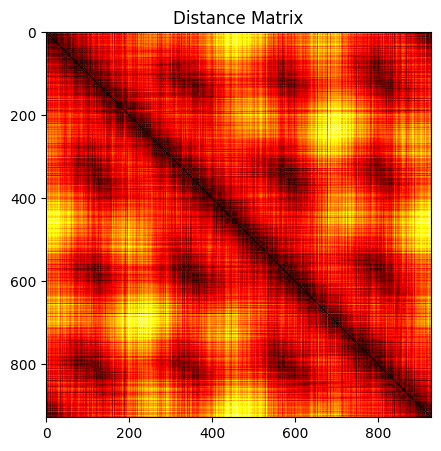

In [ ]:
distance = distance_matrix(synthetic_biological_structure, synthetic_biological_structure)
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes.imshow(distance, cmap='hot', interpolation='nearest')
# add title
axes.set_title('Distance Matrix', fontsize=12)
plt.show()

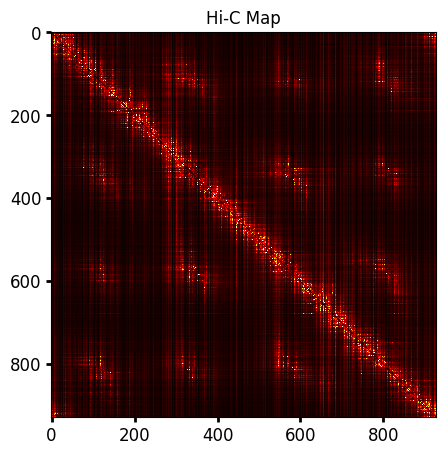

In [ ]:
# Calculate Hi-C Map
hic_matrix = compute_hic_matrix(distance, EXPONENT)
# Min Max scaling
scaler = MinMaxScaler()
hic_matrix = scaler.fit_transform(hic_matrix)

fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.imshow(hic_matrix, cmap='hot', interpolation='nearest')
# add title
axs.set_title('Hi-C Map', fontsize=12)
axs.tick_params(axis='both', which='major', labelsize=12, width=2)
plt.savefig('synthetic_biological_hic_example.png', dpi=300)
plt.show()

In [ ]:
import os

# Assuming these functions/variables are defined:
# - generate_synthetic_biological_structure()
# - distance_matrix()
# - compute_hic_matrix()
# - NB_STRUCTURES_TRAINING, NB_STRUCTURES_TESTING, EXPONENT, DIGITS_FORMAT

def synthetic_biological_data_generator(is_training=True,
                                        output_dir='/content/drive/MyDrive/STATS507/TECH3D',
                                        nb_structures_training=NB_STRUCTURES_TRAINING,
                                        nb_structures_testing=NB_STRUCTURES_TESTING,
                                        exponent=EXPONENT):
    """
    Generates synthetic 3D structures, distance matrices, and Hi-C contact matrices
    using a toroid-based model of the E. coli chromosome. Saves data in .npy binary format for efficient storage.

    Parameters:
    - is_training: Boolean, if True, generates training set; else testing set
    - output_dir: Save structure/distance/hic matrices
    - nb_structures_training: Number of training samples to generate (if is_training=True)
    - nb_structures_testing: Number of test samples to generate (if is_training=False)
    - exponent: Power-law exponent used in computing contact matrix from distance
    """

    file_name = 'train' if is_training else 'test'
    nb_structures = nb_structures_training if is_training else nb_structures_testing

    # Create folders
    struct_dir = os.path.join(output_dir, file_name, 'structure_matrices')
    dist_dir = os.path.join(output_dir, file_name, 'distance_matrices')
    hic_dir = os.path.join(output_dir, file_name, 'hic_matrices')
    os.makedirs(struct_dir, exist_ok=True)
    os.makedirs(dist_dir, exist_ok=True)
    os.makedirs(hic_dir, exist_ok=True)

    for i in tqdm(range(0, nb_structures, 2)):
        # Set seeds for reproducibility
        random.seed(i * 3 + 500)
        np.random.seed(i * 1201 + 8302)

        # Generate 3D structure (already normalized and centered)
        path = generate_synthetic_biological_structure()
        path_inverted = np.flip(path, axis=0)

        # Save structure matrices in .npy format
        np.save(os.path.join(struct_dir, f'synthetic_ecoli_structure_{DIGITS_FORMAT.format(i)}.npy'), path)
        np.save(os.path.join(struct_dir, f'synthetic_ecoli_structure_{DIGITS_FORMAT.format(i+1)}.npy'), path_inverted)

        # Compute distance matrices
        dist = distance_matrix(path, path)
        dist_flipped = np.rot90(dist, k=2)

        np.save(os.path.join(dist_dir, f'synthetic_ecoli_distance_{DIGITS_FORMAT.format(i)}.npy'), dist)
        np.save(os.path.join(dist_dir, f'synthetic_ecoli_distance_{DIGITS_FORMAT.format(i+1)}.npy'), dist_flipped)

        # Compute and normalize Hi-C matrix
        hic = compute_hic_matrix(dist, exponent)
        hic = MinMaxScaler().fit_transform(hic)
        hic_flipped = np.rot90(hic, k=2)

        np.save(os.path.join(hic_dir, f'synthetic_ecoli_hic_{DIGITS_FORMAT.format(i)}.npy'), hic)
        np.save(os.path.join(hic_dir, f'synthetic_ecoli_hic_{DIGITS_FORMAT.format(i+1)}.npy'), hic_flipped)



In [ ]:
# Training set
synthetic_biological_data_generator()
# Test set
synthetic_biological_data_generator(is_training=False)

 43%|████▎     | 216/500 [02:25<03:11,  1.48it/s]